In [1]:
import math
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error  
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files #Wrzucenie pliku csv do colaba
uploaded = files.upload()      # otwierajac normalnie plik .py nie trzeba wywolywac

Saving dane_testy.csv to dane_testy.csv


In [4]:
data = pd.read_csv("dane_testy.csv", sep = ";") #przypisanie pliku 

In [5]:
#Zamiana wartości na 0/1
data["Lokalizacja"] = data["Lokalizacja"].replace(["wiejska", "podmiejska", "miejska"], [0, 1, 1])
data["Typ"] = data["Typ"].replace(["niepubliczna", "publiczna"], [0, 1])
data["Metoda"] = data["Metoda"].replace(["standardowa", "eksperymentalna"], [0, 1])
data["Płeć"] = data["Płeć"].replace(["dziewczynka", "chłopiec"], [0, 1])
data["Obiad"] = data["Obiad"].replace(["nie kwalifikuje się", "kwalifikuje się"], [0, 1])

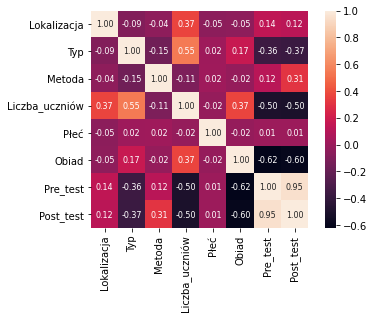

In [6]:
#Stworzenie macierzy korelacji
columns = ['Lokalizacja', 'Typ', 'Metoda', 'Liczba_uczniów', 'Płeć','Obiad','Pre_test','Post_test']
corelationMatrix = np.corrcoef(data[columns].values.T)
heatMap = sns.heatmap(corelationMatrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=columns, xticklabels=columns)
plt.show()

In [8]:
#Pre_test został wybrany jako predyktor ze wzgledu 
#na silna korelacje ze zmienną celu
x = data[['Lokalizacja', 'Typ', 'Metoda', 'Liczba_uczniów', 'Płeć','Obiad','Pre_test']] 
#zmienna celu
y = data["Post_test"]

In [9]:
#podział danych na zbiór uczący i testowy
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=300136)
x_test_cpy = x_test.copy()

x_train_cart = x_train.copy()
x_test_cart = x_test.copy()
y_train_cart = y_train.copy()
y_test_cart = y_test.copy()

In [ ]:
##################################################
#                       MLP                      #
##################################################

In [10]:
# przeprowadzamy standaryzacje min - max
scal = MinMaxScaler()
scal.fit(pd.DataFrame(x_train))
x_train_norm = scal.transform(pd.DataFrame(x_train))
x_test_norm = scal.transform(pd.DataFrame(x_test))

scal.fit(pd.DataFrame(y_train))
y_train_norm = scal.transform(pd.DataFrame(y_train))
y_test_norm = scal.transform(pd.DataFrame(y_test))

In [11]:
#Budowa sieci 
siec = MLPRegressor(hidden_layer_sizes=(8,), activation='tanh', solver='lbfgs', alpha=0.0001, max_iter = 1000, random_state=300136)
#Uczenie jej
siec_train=siec.fit(x_train_norm, y_train_norm)
#Przewidywanie
y_predict_test = siec.predict(x_test_norm)
y_predict_train = siec.predict(x_train_norm)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
#destandaryzacja

predicted_destand_test=np.zeros(y_predict_test.shape[0]) 
predicted_destand_train=np.zeros(y_predict_train.shape[0]) 
i=0
while i<= (y_predict_test.shape[0]-1):
      predicted_destand_test[i] =(y_predict_test[i]*(max(pd.DataFrame(y_test)['Post_test'])-min(pd.DataFrame(y_test)['Post_test'])))+min(pd.DataFrame(y_test)['Post_test'])
      i+=1
i=0
while i<= (y_predict_train.shape[0]-1):
      predicted_destand_train[i] =(y_predict_train[i]*(max(pd.DataFrame(y_train)['Post_test'])-min(pd.DataFrame(y_train)['Post_test'])))+min(pd.DataFrame(y_train)['Post_test'])
      i+=1

In [13]:
print('RMSE na probie uczacej',math.sqrt(round(mean_squared_error(y_train, predicted_destand_train),3))) 
print('MAE na probie uczacej',mean_absolute_error(y_train, predicted_destand_train))
print()
print('RMSE na probie testowej',math.sqrt(round(mean_squared_error(y_test, predicted_destand_test),3))) 
print('MAE na probie testowej',mean_absolute_error(y_test, predicted_destand_test))

RMSE na probie uczacej 3.1859064644147983
MAE na probie uczacej 2.543894541115198

RMSE na probie testowej 3.7664306710730786
MAE na probie testowej 3.0693732986064246


In [20]:
data_rests = x_test_cpy
#data_rests['Pre_test'] = x_test_cpy
data_rests['Post_test'] = y_test
data_rests['Predicted_test'] = predicted_destand_test.tolist()
data_rests['rests'] = y_test - predicted_destand_test.tolist()

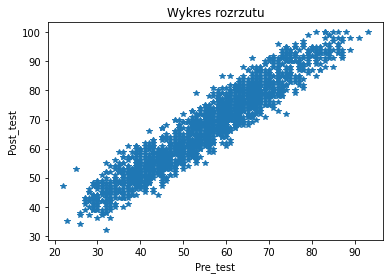

In [21]:
plt.title('Wykres rozrzutu')
plt.plot( "Pre_test", "Post_test", data=data, linestyle='none', marker='*')
plt.ylabel('Post_test')
plt.xlabel('Pre_test')
plt.show()

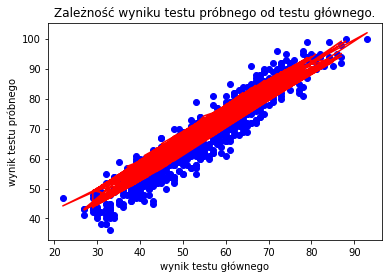

In [23]:
plt.scatter(data_rests["Pre_test"], data_rests["Post_test"], color = 'blue')
plt.plot( "Pre_test", "Predicted_test", data=data_rests, color= 'red')
plt.title('Zależność wyniku testu próbnego od testu głównego.')
plt.ylabel('wynik testu próbnego')
plt.xlabel('wynik testu głównego')
plt.show()

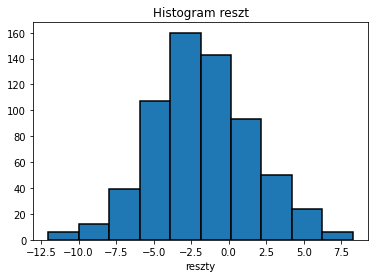

In [24]:
fig = plt.figure()
plt.hist(data_rests["rests"], edgecolor='black', linewidth=1.5);
plt.title('Histogram reszt')
plt.xlabel('reszty')
plt.show()

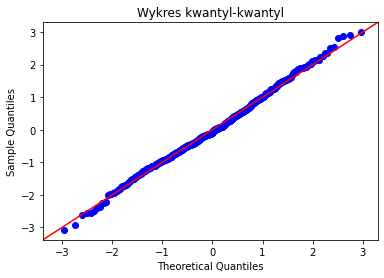

In [25]:
sm.qqplot(data_rests["rests"],fit=True,line='45')
plt.title('Wykres kwantyl-kwantyl')
plt.show()

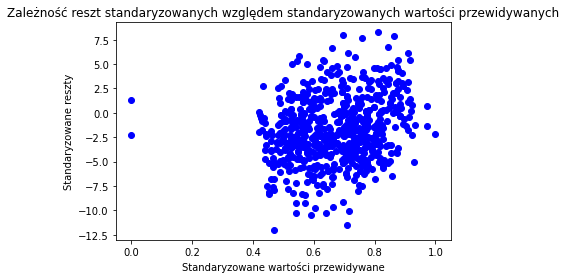

In [81]:
rests_norm=(data_rests["rests"]-min(data_rests["rests"]))/(max(data_rests["rests"])-min(data_rests["rests"]))
#y_predict_norm = [i for i in data_rests["Predicted_test"] if i != 0] #pozbycie sie elementow zerowych

minimum = min(y_predict_norm)
maximum = max(y_predict_norm)
y_predict_norm = data_rests["Predicted_test"]
y_predict_norm = (np.asarray(y_predict_norm)-minimum)/(maximum-minimum)


plt.scatter(y_predict_norm, rests, color = 'blue')
plt.title('Zależność reszt standaryzowanych względem standaryzowanych wartości przewidywanych')
plt.xlabel('Standaryzowane wartości przewidywane')
plt.ylabel('Standaryzowane reszty')
plt.show()


In [82]:
stat = shapiro(data_rests["rests"])
print('Statistics = %.3f, p-value = %.6f' %(stat[0], stat[1]))
#H0 - reszty maja rozklad normalny
#H1 - reszty maja rozklad inny niz normalny
if stat[1] > 0.05:
	print('Nie ma podstawy do odrzucenia hipotezy zerowej')
else:
	print('Nalezy odrzucic hipoteze zerowa i przyjac alternatywna')

durbinWatson = durbin_watson(data_rests["rests"])

print()
if durbinWatson > 1.8 and durbinWatson < 2.2:
    print('Durbin-Watson:', durbinWatson, " -> blisko 2 - rozkład normalny")
else:
    print('Durbin-Watson:', durbinWatson, " -> daleko od 2")

Statistics = 0.997, p-value = 0.181888
Nie ma podstawy do odrzucenia hipotezy zerowej

Durbin-Watson: 1.5898341751135447  -> daleko od 2


In [ ]:
##################################################
#                      CART                      #
##################################################

In [83]:
#Ponownie przypisujemy predyktor i zmienna celu
#Pre_test został wybrany jako predyktor ze wzgledu 
#na silna korelacje ze zmienną celu
x = data[['Lokalizacja', 'Typ', 'Metoda', 'Liczba_uczniów', 'Płeć','Obiad','Pre_test']] 
#zmienna celu
y = data["Post_test"]

In [84]:
#korzystamy z wczesniej przygotowanego podzialu na zbior uczacy i testowy
#x_train, x_test, y_train, y_test 
model = DecisionTreeRegressor(criterion="mse", max_depth=5, min_samples_split=20, min_samples_leaf=10) 
cart_train = model.fit(pd.DataFrame(x_train_cart), pd.DataFrame(y_train_cart))

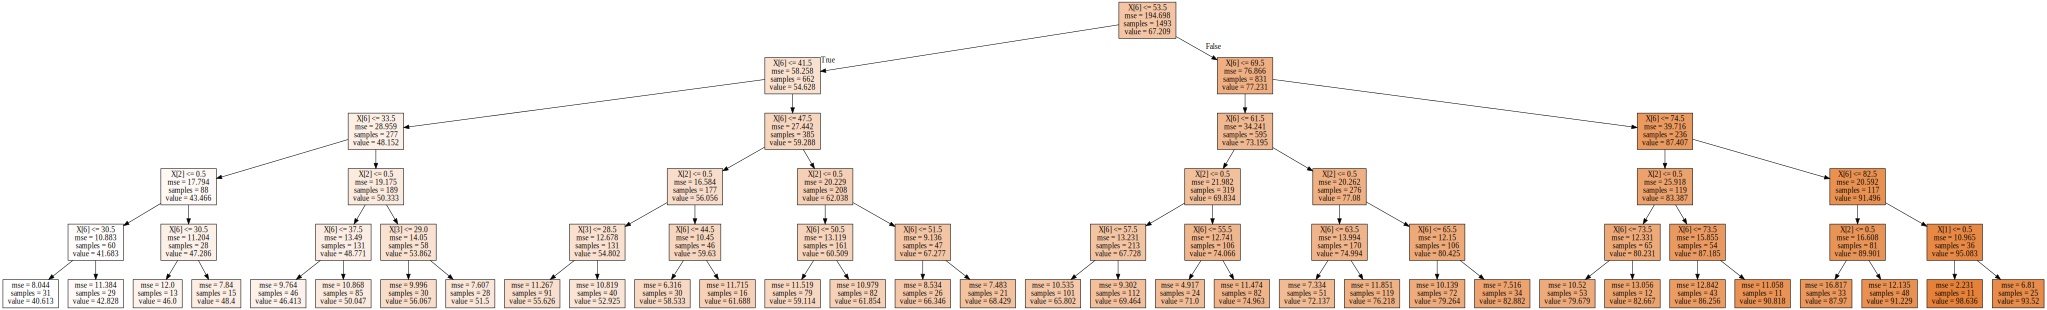

In [85]:
tree_cart=export_graphviz(cart_train,out_file=None,filled=True)
graph = graphviz.Source(tree_cart,format='png')
graph.render("./cart_tree")
graph

In [86]:
predict_train = model.predict(pd.DataFrame(x_train_cart))
predict_test = model.predict(pd.DataFrame(x_test_cart))

data_rests_cart = x_test_cart
data_rests_cart['Pre_test'] = x_test_cart
data_rests_cart['Post_test'] = y_test_cart
data_rests_cart['Predicted_test'] = predict_test.tolist()
data_rests_cart['rests'] = y_test_cart - predict_test.tolist()

In [87]:
print('RMSE na probie uczacej',math.sqrt(round(mean_squared_error(y_train_cart, predict_train),3))) 
print('MAE na probie uczacej',mean_absolute_error(y_train_cart, predict_train))
print()
print('RMSE na probie testowej',math.sqrt(round(mean_squared_error(y_test_cart, predict_test),3))) 
print('MAE na probie testowej',mean_absolute_error(y_test_cart, predict_test))

RMSE na probie uczacej 3.2135649985646784
MAE na probie uczacej 2.5431501074071132

RMSE na probie testowej 3.453548899320813
MAE na probie testowej 2.7723941341848946


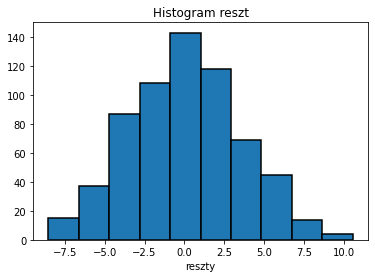

In [88]:
fig = plt.figure()
plt.hist(data_rests_cart["rests"], edgecolor='black', linewidth=1.5);
plt.title('Histogram reszt')
plt.xlabel('reszty')
plt.show()

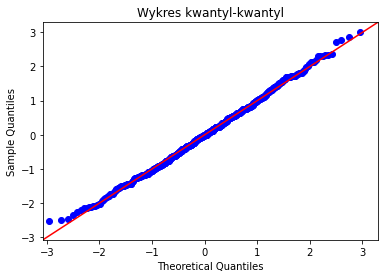

In [89]:
sm.qqplot(data_rests_cart["rests"],fit=True,line='45')
plt.title('Wykres kwantyl-kwantyl')
plt.show()

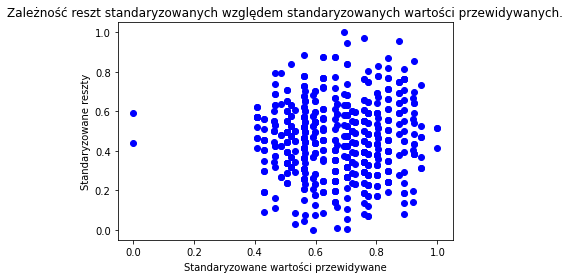

In [91]:
rests_norm=(data_rests_cart["rests"]-min(data_rests_cart["rests"]))/(max(data_rests_cart["rests"])-min(data_rests_cart["rests"]))

minimum = min(data_rests_cart['Predicted_test'])
maximum = max(data_rests_cart['Predicted_test'])
y_predict_norm = data_rests_cart["Predicted_test"]
y_predict_norm = (np.asarray(y_predict_norm)-minimum)/(maximum-minimum)

plt.scatter(y_predict_norm, rests_norm, color = 'blue')
plt.title('Zależność reszt standaryzowanych względem standaryzowanych wartości przewidywanych.')
plt.xlabel('Standaryzowane wartości przewidywane')
plt.ylabel('Standaryzowane reszty')
plt.show()

In [92]:
stat = shapiro(data_rests_cart["rests"])
print('Statistics = %.3f, p-value = %.6f' %(stat[0], stat[1]))
#H0 - reszty maja rozklad normalny
#H1 - reszty maja rozklad inny niz normalny
if stat[1] > 0.05:
	print('Nie ma podstawy do odrzucenia hipotezy zerowej')
else:
	print('Nalezy odrzucic hipoteze zerowa i przyjac alternatywna')

durbinWatson = durbin_watson(data_rests_cart["rests"])

print()
if durbinWatson > 1.8 and durbinWatson < 2.2:
    print('Durbin-Watson:', durbinWatson, " -> blisko 2 - rozkład normalny")
else:
    print('Durbin-Watson:', durbinWatson, " -> daleko od 2")

Statistics = 0.997, p-value = 0.270290
Nie ma podstawy do odrzucenia hipotezy zerowej

Durbin-Watson: 1.9863300844642438  -> blisko 2 - rozkład normalny
